### `DemandSupplySimulation` 環境設定方法

<p>Click to copy each command:</p>

1. **Open Terminal**  
   - Click on `Terminal` -> `New Terminal`

2. **Run Environment Creation Command**
   - Command: `conda env create -f environment.yml`  
     <button onclick="navigator.clipboard.writeText('conda env create -f environment.yml')">Copy Command</button>

3. **Update Existing Environment**  
   - Command: `conda env update -f environment.yml --prune`  
     <button onclick="navigator.clipboard.writeText('conda env update -f environment.yml --prune')">Copy Command</button>

4. **If `conda` is Not Available**  
   - Install conda mini.

### Frequently Used Commands
1. **List Existing Environment**  
   - Command: `conda env list`  
     <button onclick="navigator.clipboard.writeText('conda env list')">Copy Command</button>

# 最初に実行するコード

In [ ]:
# モジュールを強制的にリロード
import pypsa_tepsco
importlib.reload(pypsa_tepsco)

# 太陽光発電データを取得してCSV保存(一度きり実行)
file_name = 'pypsa-japan-10BusModel.xlsx'
output_file = './data/processed/solar_time_series.csv'
Year_of_analysis = 2024
pypsa_tepsco.GetSolarTimeSeriesData(file_name, output_file, Year_of_analysis)


# メイン（データの読み込み⇒計算）

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


太陽光データを読み込んでいます: ./data/processed/solar_time_series.csv
太陽光発電機の数: 9
太陽光発電機: ['太陽光（北海道）', '太陽光（東北）', '太陽光(東京)', '太陽光(中部)', '太陽光(北陸)', '太陽光(関西)', '太陽光(中国)', '太陽光(四国)', '太陽光(九州)']
  ✓ 太陽光（北海道） に 北海道 のデータを割り当てました
  ✓ 太陽光（東北） に 東北 のデータを割り当てました
  ✓ 太陽光(東京) に 東京 のデータを割り当てました
  ✓ 太陽光(中部) に 中部 のデータを割り当てました
  ✓ 太陽光(北陸) に 北陸 のデータを割り当てました
  ✓ 太陽光(関西) に 関西 のデータを割り当てました
  ✓ 太陽光(中国) に 中国 のデータを割り当てました
  ✓ 太陽光(四国) に 四国 のデータを割り当てました
  ✓ 太陽光(九州) に 九州 のデータを割り当てました
最適化を開始します...
Ramp制約を追加中...


INFO:linopy.model: Solve problem using Highs solver


  ✓ Ramp up制約を追加: 50個のリンク
  ✓ Ramp down制約を追加: 50個のリンク


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 24.83it/s]
INFO:linopy.io: Writing time: 1.55s
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 24.83it/s]
INFO:linopy.io: Writing time: 1.55s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61992 primals, 222122 duals
Objective: 7.78e+10
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61992 primals, 222122 duals
Objective: 7.78e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, Link-ramp_limit_up, Link-ramp_limit_down were not assigned to the ne

最適化が完了しました。


INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network/optimized_network_2024.nc contains: links, carriers, buses, loads, stores, generators, sub_networks


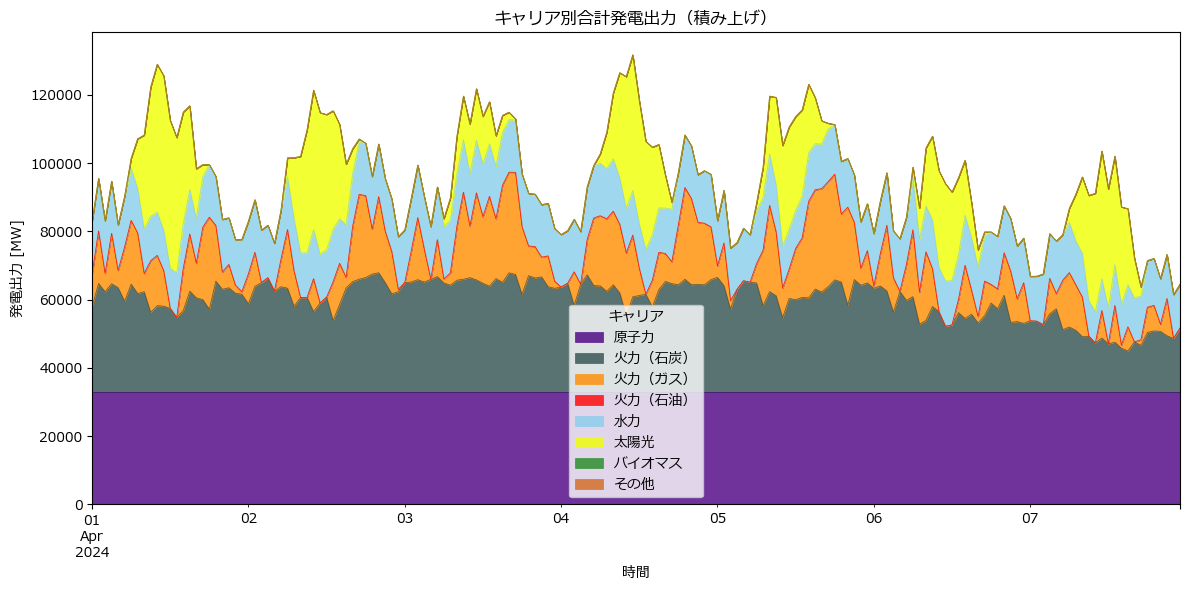

In [27]:
%reset -f
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.getcwd())

# モジュールを強制的にリロード
import pypsa_tepsco
importlib.reload(pypsa_tepsco)

pd.set_option('display.max_columns', None)
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

Year_of_analysis = 2024
demand_change_compared_to_2024 = 10  # %
file_name = "./data/raw/pypsa-japan-10BusModelV2.xlsx"  # ネットワーク＋需要データを含むExcelファイル

# Renewable Ninja API Key（取得方法: https://www.renewables.ninja/register）
renewable_ninja_api_key = "0ee68c7853037dcd2235f771d349d104e68996cf"  # ここにAPIキーを入力してください

# スナップショット作成
snapshots = pd.date_range(f"{Year_of_analysis}-04-01 00:00",
                          f"{Year_of_analysis}-04-07 23:00",
                          freq="h")
snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]

# ネットワークデータ読み込み
network = pypsa.Network(file_name)
network.set_snapshots(snapshots)

# 需要データ読み込み（同じExcelファイルの'Demand'シートから）
pypsa_tepsco.import_demand_data_from_network_file(network, file_name, demand_change_compared_to_2024)

# 太陽光時系列データの読み込み
solar_data_file = './data/processed/solar_time_series.csv'
pypsa_tepsco.SolarTimeSeriesDataSet(network, solar_data_file)


# Ramp制約を追加する関数（PyPSA v1.0以降）
def add_ramp_constraints(n, snapshots):
    """
    Ramp制約を最適化モデルに追加
    - ramp_limit_up: 出力増加率の制限（p_nomに対する比率）
    - ramp_limit_down: 出力減少率の制限（p_nomに対する比率）
    """
    from linopy import Model
    
    # Linkコンポーネントに対するRamp制約
    if hasattr(n, 'links') and len(n.links) > 0:
        # ramp_limit_upが設定されているリンクを抽出
        links_with_ramp_up = n.links[n.links['ramp_limit_up'].notna() & (n.links['ramp_limit_up'] > 0)].index
        if len(links_with_ramp_up) > 0:
            # 出力の時間差分を計算
            p_diff = n.model["Link-p"].diff("snapshot")
            # Ramp up制約: p(t) - p(t-1) <= ramp_limit_up * p_nom
            ramp_up_limit = n.links.loc[links_with_ramp_up, 'ramp_limit_up'] * n.links.loc[links_with_ramp_up, 'p_nom']
            n.model.add_constraints(
                p_diff.loc[:, links_with_ramp_up] <= ramp_up_limit,
                name="Link-ramp_limit_up"
            )
            print(f"  ✓ Ramp up制約を追加: {len(links_with_ramp_up)}個のリンク")
        
        # ramp_limit_downが設定されているリンクを抽出
        links_with_ramp_down = n.links[n.links['ramp_limit_down'].notna() & (n.links['ramp_limit_down'] > 0)].index
        if len(links_with_ramp_down) > 0:
            p_diff = n.model["Link-p"].diff("snapshot")
            # Ramp down制約: p(t-1) - p(t) <= ramp_limit_down * p_nom
            # つまり: -p_diff <= ramp_limit_down * p_nom
            ramp_down_limit = n.links.loc[links_with_ramp_down, 'ramp_limit_down'] * n.links.loc[links_with_ramp_down, 'p_nom']
            n.model.add_constraints(
                -p_diff.loc[:, links_with_ramp_down] <= ramp_down_limit,
                name="Link-ramp_limit_down"
            )
            print(f"  ✓ Ramp down制約を追加: {len(links_with_ramp_down)}個のリンク")

# 最適化実行（Ramp制約を有効化）
print("最適化を開始します...")
print("Ramp制約を追加中...")
network.optimize(
    solver_name='highs',
    extra_functionality=add_ramp_constraints
)
print("最適化が完了しました。")

# ネットワークデータ保存
network.export_to_netcdf(f'complete_network/optimized_network_{Year_of_analysis}.nc')

# 発電量集計・プロット
pypsa_tepsco.plot_total_generation_by_carrier(network)

In [28]:
network.stores

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_nom_set,e_min_pu,e_max_pu,e_initial,e_initial_per_period,e_cyclic,e_cyclic_per_period,p_set,q_set,e_set,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
新冠,新冠,,水,1600.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,1600.0
高見,高見,,水,1712.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,1712.0
京極,京極,,水,4800.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,4800.0
第二沼沢,第二沼沢,,水,3680.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,3680.0
今市,今市,,水,8400.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,8400.0
矢木沢,矢木沢,,水,1920.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,1920.0
玉原,玉原,,水,9600.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,9600.0
塩原,塩原,,水,7200.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,7200.0
安曇,安曇,,水,4984.0,0.0,False,0.0,inf,NaN,0.0,1.0,0.0,False,False,False,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,True,0,inf,4984.0
